Create a pairs basket with returns of SVXY (Short VIX ETF) and VIRT (Virtu financial). Expect some negative correlation when VIX spikes, so VIRT is a hedge that still has a positive return. 

Experiment with rebalancing ratios and frequencies for the basket. Create a rebalancing surface with axis being rebalancing ratio, frequency of rebalancing, and CAGR over the test period. Plot it.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
import matplotlib.pyplot as plt

In [2]:
#Get data
tickers= ['SVXY', 'VIRT']
start_date= dt.datetime(2015,6,1)
end_date= dt.datetime(2020,12,31)
SVXY_VIRT_df= yf.download(tickers,start= start_date, end= end_date)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [3]:
#convert date column to datetime index
SVXY_VIRT_df.index= pd.to_datetime(SVXY_VIRT_df.index)
#turn prices into returns
daily_ret= SVXY_VIRT_df.pct_change()
daily_ret= daily_ret.dropna()

Data is now in a usable form. Nice. 

Now let's make some functions. The main one will return a dataframe of daily returns (pun not intended) that reflect our strategy. As inputs, it will take the dataset, the rebalancing weight on asset 1, and the rebalancing frequency. 

- Figuring out how to iterate over a datetime index is hard. Instead, it's easier to use iloc and just use the positions of each value, which is actually better since we aren't restricted by column names or any datetime fiascos

In [309]:
def rebalanced_strat(daily_ret, w, freq):
    """df must only have 2 columns, w is weight on asset 1, freq is number of days between rebalancing"""
    portfolio= []
    wallet= 100
    A= w*wallet
    B= (1-w)*wallet
    
    for n in range(1407):
        portfolio.append(wallet)
        
        A_ret= daily_ret.iloc[n,0]
        B_ret= daily_ret.iloc[n,1]

        A= A*(1+ A_ret)
        B= B*(1 + B_ret)
        wallet= A + B
        if n%freq==0:
            A= w*wallet
            B= (1-w)*wallet

    return (portfolio[-1]/portfolio[0])**(1/5)-1
 

To make a plot of the rebalancing surface, we need a 3D array. This was a real pain in the ass to figure out. Even now, I don't know how to make 1 3D array. But I don't need to. All I need is a meshgrid (rectangle) of the weights and frequencies, and then an array of the returns corresponding to them. 

Now I can plot. 

Turns out my Z axis wasn't varying along the rebalancing period axis. Figuring out how to create an array of the right dimensions probably took close to an hour and a half. And the solution was about 6 lines- which I had to figure out myself, no google.
https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

https://www.youtube.com/watch?v=xd2sZ8rXLZI

In [325]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def getZ(X,Y):
    Q = []
    q= []
    for n in range(5):
        q=[]
        for m in range(5):
            xcell= X[n][m]
            ycell= Y[n][m]
            q.append(rebalanced_strat(daily_ret, xcell, ycell))
        Q.append(q)
    Q1= np.array(Q)
    return Q1


w= np.linspace(0,1,5)
f= np.linspace(1,100,5)

X, Y = np.meshgrid(w, f)
Z = getZ(X, Y)

def plotter(E,A):
    fig = plt.figure(figsize=[15,7])
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z,
                    cmap='plasma', edgecolor='none')
    ax.set_title('Rebalancing Surface')
    ax.set_xlabel('Weight on SVXY')
    ax.set_ylabel('Rebalancing Frequency (Days)')
    ax.set_zlabel('CAGR(5Yr)')
    ax.view_init(elev=E, azim=A)
    plt.show()


In [320]:
Q1= np.array(Q)
Q1.shape

(20, 11)

In [312]:
Z.shape

(20, 11)

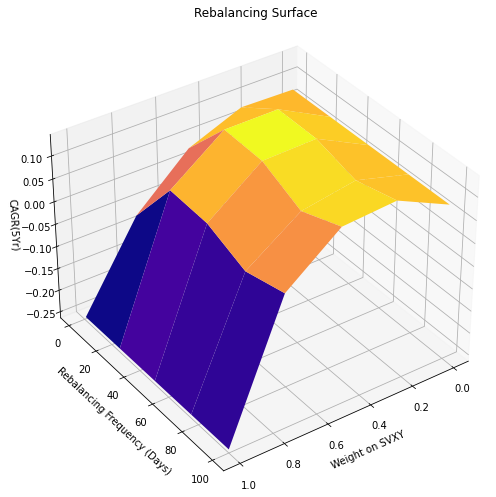

In [324]:
plotter(35,55)

In [318]:
Z.shape

(20, 11)

In [335]:
Z[1][

0.13789749914239358

In [339]:
[1][1]
Y[1][1]

25.75